TODO:


Currently:
- Article is about caching as opposed to persisting in general
- Show how to view memory usage due to cache
- Show some analysis where caching is appropriate
- Touch on execution plan and catalyst optimiser
- Summary and tips on when to cache and when not to cache

Proposed structure:
- Article is about persisting
- Mention execution plan and catalyst optimiser (link to dedicated article?)
- Discussion on persisting strategy
- Link to caching article
- Link to dedicated article on checkpointing/staging tables



- persisting strategy and mention execution plan and cat optimiser
- checkpointing and staging tables
- caching


# Persisting in Spark

Persisting Spark DataFrames is done to improve efficiency. There are two different cases where persisting can be useful:

1. Lineage of the DataFrame is long and complex
2. Stop unnecessary repetitions of processes

In this article we discuss the different methods of persisting data with Spark, their advantages and disadvantages.

## Lineage, execution plan and the catalyst optimiser

Before we discuss persistance we should discuss lineage, the execution plan and the catalyst optimiser.

We know that Spark uses lazy evaluation, meaning it doesn't process data until it has to e.g. infering the schema of a file, a row count, returning some data using `.show()`/`head() %>% collect()` or writing data to disk. As we execute DataFrame transformations Spark tracks the lineage of the DataFrame and creates an execution plan. When we execute an action Spark executes the plan. This is quite different to how regular Python, pandas or R works. Why does Spark work in this way?  Because Spark will find more efficient ways to process the data than just following our commands one after the other, and when it comes to processing big data, this is really useful. 

The way Spark optimises our jobs is using the [catalyst optimiser](https://databricks.com/glossary/catalyst-optimizer) and the [tungsten optimiser](https://databricks.com/glossary/tungsten). The former uses a list of rules to change our code into a more efficient strategy, whereas the latter performs optimisations on the hardware. If we want to see how Spark will or has processed a DataFrame we can look at the execution plan. For a quick view you can apply the `.explain()`/`explain` functions to DataFrames in PySpark/sparklyr. The `full` argument can be set to true to see how the catalyst optimiser has taken the original Spark code and optimised it to reach the final version, called the Physical Plan. Examples are given in the **Joins** article on how to read the output of the `explain` function. The execution plan is also given in the form of a DAG diagram within the SQL tab in the Spark UI. Examples are given in the **Cache** article on understanding these diagrams.

## Breaking DataFrame lineage

As we apply more transformations to our DataFrames the lineage grows and so does the execution plan. If the lineage is long and complex Spark will struggle to optimise the plan and take a long time to process the DataFrame. 

Let's say we are executing an interative algorithm on a DataFrame, for example we apply some calculation to a column to create a new column and use this new column as the input to the calculation in the next iteration. We notice that Spark struggles to execute the code after 10 iterations. What we can try to solve this issue is every 5 iterations we write the DataFrame out to disk and read it back in for the next iteration. Writing the data out to disk is a form of [persistance](https://en.wikipedia.org/wiki/Persistence_(computer_science)), and so this is an example where persistance is used in Spark to break the lineage of a DataFrame.

An example of persistance in an interative process is given in the article on checkpoints and staging tables.

There are other forms of persistance, we'll use a different example below.

## Remove repeated processing

The default behaviour of Spark when it encounters an action is to execute the full execution plan from when the data was read in from disk to the output of the action which was called. There are some optimisations provided by the tungsten optimiser that diverge from this default behaviour, but we will ignore these for now.

Now imagine we read in a dataset and perform some cleaning transformations to get the data ready for some analysis. We then perform three different aggregations on the cleansed data and write these summary tables to disk. If we consider how Spark executes the full execution plan when it gets to an action, we see that Spark will repeat the cleaning transformations for each summary table. Surely it would be more efficient to clean the data once and not three times (one for each aggregation)? This is another case where persisting can help. A possible solution here would be to persist the cleansed data into memory using a cache before performing the aggregations. This means that the first tiome Spark executes the full plan it will create a copy of the cleansed data in the executor memory, so next time the DataFrame is used it can be accessed quickly and efficiently.

An example of using cache to remove repeated processing is given in the cache article.

## Different types of persistance


- On disk
- In memory

- Checkpoint/staging tables
- Cache (persist)


## Cache gone wrong

## Persisting strategy

In [32]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [33]:
spark = (
    SparkSession.builder.appName("persist")
    .config("spark.executor.memory", "1g")
    .config("spark.executor.cores", 1)
    .config("spark.dynamicAllocation.enabled", "true")
    .config("spark.dynamicAllocation.maxExecutors", 2)
    .config("spark.shuffle.service.enabled", "true")
    .config("spark.ui.showConsoleProgress", "false")
    .enableHiveSupport()
    .getOrCreate()
)

## `.persist` or `.cache`?

`.persist()` is a general form of `.cache()`. It is the same as calling `.cache()` where we are able to specify where to store the data, e.g. use memory but allow spill over to disk if the executor memory is full. The `.persist()` method takes a `StorageLevel` argument to specify where to cache the data. Options for storage levels are:  

`MEMORY_ONLY`

`MEMORY_AND_DISK`  

`MEMORY_ONLY_SER`   

`MEMORY_AND_DISK_SER`   

`DISK_ONLY`  

`OFF_HEAP`   

Using the `MEMORY_ONLY` option is equivalent to `.cache()`. More information on  storage levels can be found in the [Apache Spark documentation](https://spark.apache.org/docs/2.4.0/rdd-programming-guide.html#rdd-persistence)

There's an example below to see how this is used, first we will unpersist the previous `.cache()`

In [38]:
people.unpersist()

DataFrame[id: bigint, age: int, sex: string, eye_colour: string]

In [39]:
from pyspark import StorageLevel
people.persist(StorageLevel.DISK_ONLY).count()

5000

Before we move on, head back to the Spark UI and have a look at how much space the `people` DataFrame uses on disk.

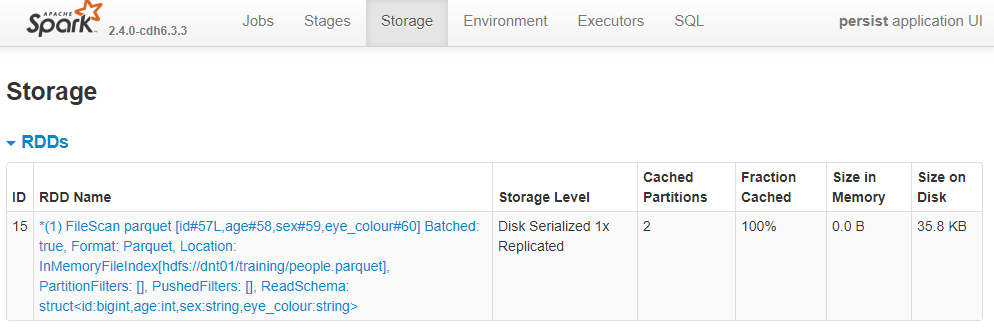

Is this what you expected? Why is this number different?

[Databricks](https://en.wikipedia.org/wiki/Databricks), a company founded by the creators of Apache Spark, suggest not bothering with `.persist()`. The are cases where you might want to `cache()`, write to disk or `.checkpoint()` (see exercises), but `.persist()` is not as efficient as these options. 

In [40]:
people.unpersist()

DataFrame[id: bigint, age: int, sex: string, eye_colour: string]

### For R users

<span style="color:blue">The syntax to remove tables by name from memory is,</span>
    
`tbl_uncache(sc, "people")`

<span style="color:blue">And to persist data using different storage options you can use,</span>
    
`sdf_persist(people, storage.level = "DISK_ONLY") %>% count()`

<span style="color:blue">Note you will need to pipe this into a `count()`</span>


In [62]:
# Solution 3

# Note these answers were obtained after running the notebook all the way through including solutions to 1 and 2.

# Get the full plan for the rescue DataFrame
rescue.explain(True)

# Reading from the bottom of the == Parsed Logical Plan ==:
# +- Relation > reading in the csv file
#  +- Repartition 2 > repartition the DataFrame
#   +- Project > drop some columns (the list of columns is shorter than previously)
#    +- The next 7 Projects > rename 7 columns (note the SQL syntax e.g. PumpCount AS EngineCount)
#     +- Project > change format of DateTimeOfCall column (to_date(DateTimeOfCall, Some(dd/MM/yyyy)) AS DateTimeOfCall)
#      +- Project > add the InicidentDuration column ((JobHours / EngineCount) AS IncidentDuration)
#       +- Filter > drop nulls in TotalCost and IncidentDuration

# Looking at the == Physical Plan ==:
# +- FileScan > quick look at file to determine schema
#  +- Filter > drop nulls
#   +- Exchange > this means a shuffle, which was incured by the repartition
#    +- Project > drop columns, rename 7 columns, change format of DateTimeOfCall, add new column (all in one step)

# Things to note:
# - Fewer steps. The Projects from the Parsed Logical Plan were condensed into one.
# - Change of order. The catalyst optimiser moved the filter as early as possible to process less data later.

# Although Spark changes the order for us, it's good practice when using big data to move filters early on in processing.

== Parsed Logical Plan ==
'Project [IncidentNumber#1855, DateTimeOfCall#2074, CalYear#1857, FinYear#1858, TypeOfIncident#1859, EngineCount#1927, JobHours#2032, HourlyCost#1969, ('TotalCost * 2) AS TotalCost#3156, Description#1948, AnimalGroup#2053, OriginOfCall#2011, PropertyType#1867, PropertyCategory#1868, SpecialServiceTypeCategory#1869, SpecialServiceType#1870, Ward#1872, Borough#1874, StnGroundName#1875, PostcodeDistrict#1876, IncidentDuration#2095]
+- Filter AtLeastNNulls(n, TotalCost#1990,IncidentDuration#2095)
   +- Project [IncidentNumber#1855, DateTimeOfCall#2074, CalYear#1857, FinYear#1858, TypeOfIncident#1859, EngineCount#1927, JobHours#2032, HourlyCost#1969, TotalCost#1990, Description#1948, AnimalGroup#2053, OriginOfCall#2011, PropertyType#1867, PropertyCategory#1868, SpecialServiceTypeCategory#1869, SpecialServiceType#1870, Ward#1872, Borough#1874, StnGroundName#1875, PostcodeDistrict#1876, (JobHours#2032 / EngineCount#1927) AS IncidentDuration#2095]
      +- Project [In